In [ ]:
import tensorflow as tf
from google.cloud import storage
import tensorflow_datasets as tfds
import os
from glob import glob
from google.colab import auth
import cv2
import numpy as np
from tqdm import tqdm_notebook
import json
import matplotlib.pyplot as plt

auth.authenticate_user()

!gdown --id 1quc2K7HfoEm8YRspAkTNjGaTamZu97WN
!unzip bdd100k.zip

In [ ]:
def imshow(image):
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(image)
    
def draw_boxes_cv2(image, bbox_list):
    img = np.uint8(image).copy()
    bbox_list = np.array(bbox_list, dtype=np.int32)
    for box in bbox_list:
        img = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), [0, 0, 200], 3)
    return img

In [22]:
train_image_paths = sorted(
    glob('bdd100k/images/100k/train/*'))
train_label_paths = sorted(
    glob('bdd100k/labels/100k/train/*'))
validation_image_paths = sorted(
    glob('bdd100k/images/100k/val/*'))
validation_label_paths = sorted(
    glob('bdd100k/labels/100k/val/*'))

print('Found training {} images'.format(len(train_image_paths)))
print('Found training {} labels'.format(len(train_label_paths)))
print('Found validation {} images'.format(len(validation_image_paths)))
print('Found validation {} labels'.format(len(validation_label_paths)))

class_map = {value: idx for idx, value in enumerate(['bus',
                                                     'traffic light',
                                                     'traffic sign',
                                                     'person',
                                                     'bike',
                                                     'truck',
                                                     'motor',
                                                     'car',
                                                     'train',
                                                     'rider'])}
for image, label in zip(train_image_paths, train_label_paths):
    assert image.split(
        '/')[-1].split('.')[0] == label.split('/')[-1].split('.')[0]
for image, label in zip(validation_image_paths, validation_label_paths):
    assert image.split(
        '/')[-1].split('.')[0] == label.split('/')[-1].split('.')[0]

Found training 70000 images
Found training 70000 labels
Found validation 10000 images
Found validation 10000 labels


In [23]:
def get_label(label_path, class_map, input_shape=512):
    with open(label_path, 'r') as f:
        temp = json.load(f)
    bbox = []
    class_ids = []
    for obj in temp['frames'][0]['objects']:
        if 'box2d' in obj:
            x1 = obj['box2d']['x1']
            y1 = obj['box2d']['y1']
            x2 = obj['box2d']['x2']
            y2 = obj['box2d']['y2']
            bbox.append(np.array([x1, y1, x2, y2]))
            class_ids.append(class_map[obj['category']])
    bbox = np.array(bbox, dtype=np.float32)
    class_ids = np.array(class_ids, dtype=np.float32)[..., None]
    return np.concatenate([bbox, class_ids], axis=-1)
  
train_labels = []
validation_labels = []

for path in tqdm_notebook(train_label_paths):
    train_labels.append(get_label(path, class_map))
for path in tqdm_notebook(validation_label_paths):
    validation_labels.append(get_label(path, class_map))

In [ ]:
def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def intlist_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def floatlist_feature(value_list):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value_list))

def make_example(image_path, label):
    with tf.gfile.GFile(image_path, 'rb') as fid:
        raw_image = fid.read()
    dims = [720, 1280]
    bbox = label[:, :4]
    class_id = label[:, 4]
    feature = {
        'image' : bytes_feature(raw_image),
        'xmins': floatlist_feature(bbox[:, 0] / dims[1]),
        'ymins': floatlist_feature(bbox[:, 1] / dims[0]),
        'xmaxs': floatlist_feature(bbox[:, 2] / dims[1]),
        'ymaxs': floatlist_feature(bbox[:, 3] / dims[0]),
        'labels': floatlist_feature(class_id)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecord(image_list, labels_list, path=''):
    with tf.io.TFRecordWriter(path) as writer:
        for image_path, label in tqdm_notebook(zip(image_list, labels_list), total=len(image_list)):
            example = make_example(image_path, label)
            writer.write(example.SerializeToString())
            
            
def create_dataset(images, labels, prefix='', folder='data', n_shards=8):
    n_samples = len(images)
    step_size = n_samples//n_shards + 1
    for i in range(0, n_samples, step_size):
        path = '{}/{}_000{}.tfrecords'.format(folder, prefix, i//step_size)
        write_tfrecord(images[i:i+step_size], labels[i:i+step_size], path)

In [ ]:
!mkdir tfrecords


In [27]:
write_tfrecord(validation_image_paths[:100], validation_labels[:100], path='tfrecords/test.tfrecord')

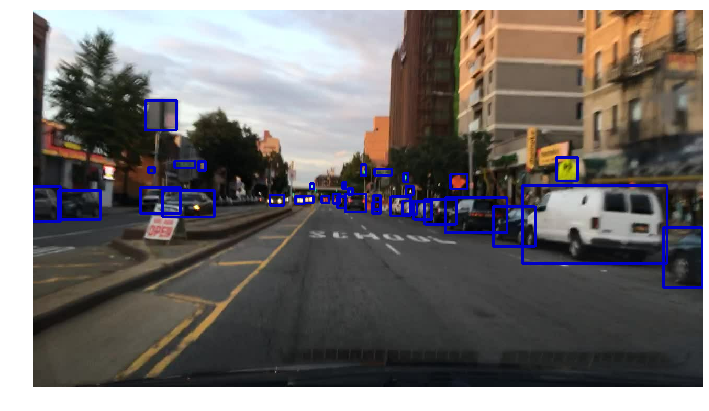

In [29]:
feature_description = {
    'image' : tf.io.FixedLenFeature([], tf.string),
    'xmins': tf.io.VarLenFeature(tf.float32),
    'ymins': tf.io.VarLenFeature(tf.float32),
    'xmaxs': tf.io.VarLenFeature(tf.float32),
    'ymaxs': tf.io.VarLenFeature(tf.float32),
    'labels': tf.io.VarLenFeature(tf.float32)
}

@tf.function
def parse_example(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(parsed_example['image'])
    image_dims = tf.cast(tf.shape(image)[:2], dtype=tf.float32)[::-1]
    bboxes = tf.stack([
        tf.sparse_tensor_to_dense(parsed_example['xmins']),
        tf.sparse_tensor_to_dense(parsed_example['ymins']),
        tf.sparse_tensor_to_dense(parsed_example['xmaxs']),
        tf.sparse_tensor_to_dense(parsed_example['ymaxs'])
    ], axis=-1) * tf.tile(image_dims, [2])
    class_ids = tf.sparse_tensor_to_dense(parsed_example['labels'])
    return image, bboxes, class_ids


train_files = tf.data.Dataset.list_files('tfrecords/*')
train_dataset = train_files.interleave(tf.data.TFRecordDataset, 
                                       cycle_length=4, 
                                       block_length=16,
                                       num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
with tf.Session() as sess:
    x = sess.run(train_dataset.make_one_shot_iterator().get_next())
img = x[0]
boxes = x[1]
img_ = draw_boxes_cv2(img, boxes)
imshow(img_)

In [ ]:
!mkdir BDD100k

In [32]:
create_dataset(train_image_paths, train_labels, prefix='train', folder='BDD100k', n_shards=8*2)
create_dataset(validation_image_paths, validation_labels, prefix='validation', folder='BDD100k', n_shards=8*2)

In [35]:
storage_client = storage.Client()
buckets = list(storage_client.list_buckets())
buckets

[<Bucket: srihari-datasets>]

In [36]:
for file in glob('BDD100k/*'):
    blob = buckets[0].blob(file) 
    print('uploading file', file)
    blob.upload_from_filename(file)

uploading file BDD100k/validation_0008.tfrecords
uploading file BDD100k/validation_0001.tfrecords
uploading file BDD100k/validation_0000.tfrecords
uploading file BDD100k/validation_00013.tfrecords
uploading file BDD100k/validation_0007.tfrecords
uploading file BDD100k/train_0007.tfrecords
uploading file BDD100k/train_00013.tfrecords
uploading file BDD100k/validation_0003.tfrecords
uploading file BDD100k/validation_00012.tfrecords
uploading file BDD100k/train_00015.tfrecords
uploading file BDD100k/validation_0009.tfrecords
uploading file BDD100k/validation_0002.tfrecords
uploading file BDD100k/train_0003.tfrecords
uploading file BDD100k/train_0005.tfrecords
uploading file BDD100k/train_0001.tfrecords
uploading file BDD100k/train_0004.tfrecords
uploading file BDD100k/train_0009.tfrecords
uploading file BDD100k/train_0008.tfrecords
uploading file BDD100k/train_00010.tfrecords
uploading file BDD100k/validation_0004.tfrecords
uploading file BDD100k/train_0002.tfrecords
uploading file BDD100